# Visual P300 example

## Acknowledgement

The code and public EEG dataset modified from:
- **https://github.com/neurotechx/eeg-notebooks**
- **https://github.com/alexandrebarachant/pyRiemann**
- **https://github.com/alexandrebarachant/muse-lsl**

Please install necessary libraries: 
- pip install -U pandas numpy seaborn matplotlib mne scikit-learn pyriemann
- you can use "pip list" (or pip3 list) to check all your libs

# Your homowork tasks:
- report mean AUCs for all available subjects using all sessions together for each subject (session = 'all')
- as an additional possible option try to propose other cross-validation splits or even classifiers to boost the AUC results for each subject 

In [1]:
import os
import sys
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from mne import find_events, Epochs, combine_evoked

import utils

## Load data into MNE objects

In [2]:
subject = 2 # this is where we choose subject (1,2,3 available in your homework)
session = 'all' # this is session number: (1~3 for subject1; 1~2 for subject2; 1~3 for subject3)

# it is possible to use session = 'all' to use all sessions available for a single subject

raw = utils.load_data(os.getcwd(), 
                      sfreq=256., 
                      subject_nb=subject, 
                      session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30744
    Range : 0 ... 30743 =      0.000 ...   120.090 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ..

## Filtering

We filter data between 1Hz and 30Hz

In [3]:
raw.filter(1,30, method='iir')

Filtering raw data in 8 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<RawArray | 5 x 245856 (960.4 s), ~9.4 MB, data loaded>

## Epoching

- Here we epoch data for -100ms to 600ms after the stimulus
- We reject every epochs were the signal exceed 100 uV in order to remove eye-blinks

In [4]:
events = find_events(raw)
event_id = {'Non-Target': 1, 'Target': 2}

epochs = Epochs(raw, events=events, 
                event_id=event_id, 
                tmin = -0.1, 
                tmax = 0.6, 
                baseline=(-0.1, 0.0),
                reject={'eeg': 80e-6}, 
                preload=True, 
                verbose=False, 
                picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

1548 events found
Event IDs: [1 2]
sample drop %:  2.454780361757103


Number of events,1510
Events,Non-Target: 1275Target: 235
Time range,-0.102 – 0.602 sec
Baseline,-0.100 – 0.000 sec


# Epoch average

## Let's see averaged target (P300-generating) responses

Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


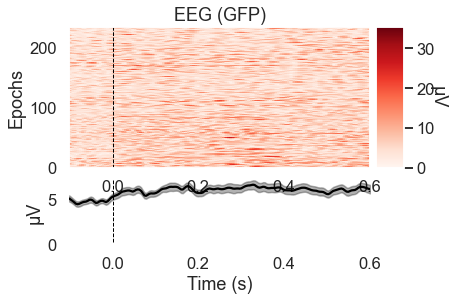

In [7]:
epochs['Target'].plot_image();

## Let's see averaged non-target (ignored) responses

Not setting metadata
1275 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


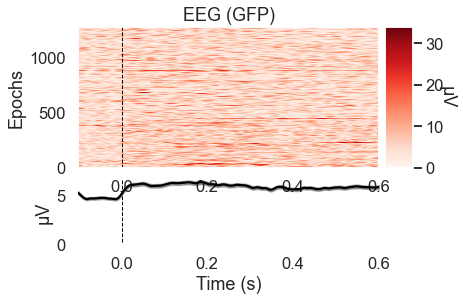

In [8]:
epochs['Non-Target'].plot_image();

# Classification or response decoding

## Let's use different classification pipelines:
- **Vectorized ERPs + LDA:**  Vectorization of the trial electrodes + LDA = the classic BCI classification approach
- **Covariances of ERPs + TS + LDA:** EEG covariance matrix features + tangent space mapping = the Riemannian geometry based approach
- **Covariances of ERPs  + MDM:**: EEG covariance matrix features + minimun distance to mean (MDM) classifier = a very simple, yet effective Riemannian geometry classification approach

## We evaluate results in a cross-validation setting with f1 as metric for binary unbalanced classification problem

In [10]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM


clfs = OrderedDict()

clfs['Vectorized ERPs + LDA'] = make_pipeline(Vectorizer(), 
                                              LDA())
clfs['Covariances of ERPs + TS + LDA'] = make_pipeline(ERPCovariances(), 
                                                       TangentSpace(), 
                                                       LDA())
clfs['Covariances of ERPs + MDM'] = make_pipeline(ERPCovariances(), 
                                                  MDM())
clfs['Covariances of ERPs + TS + FNN'] = make_pipeline(ERPCovariances(),
                                                       TangentSpace(),
                                                       MLPClassifier(random_state=1, 
                                                                     activation='relu', 
                                                                     solver='adam', 
                                                                     max_iter=10000,
                                                                     early_stopping=True, 
                                                                     hidden_layer_sizes=[256, 64]
                                                                    )
                                                      )

## Format data

In [11]:
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

In [12]:
print('Input feature tensor size = ', X.shape)
print('Label vector size = ', y.shape)
print('Unique labels = ', np.unique(y, return_counts=True)[0], ' and counts = ', np.unique(y, return_counts=True)[1])

Input feature tensor size =  (1510, 4, 181)
Label vector size =  (1510,)
Unique labels =  [1 2]  and counts =  [1275  235]


In [13]:
# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, 
                            test_size=0.10, 
                            random_state=42)

In [14]:
# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    try:
        print('- ' + m)
        res = cross_val_score(clfs[m], 
                              X, 
                              y, 
                              scoring='f1', 
                              cv=cv, 
                              n_jobs=-1
                             )
        
        print('    -> median(f1 score) = ' + str(np.median(res)))
        
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass
    
results = pd.DataFrame(data=auc, columns=['f1 score'])
results['Method'] = methods

print('Done!')

- Vectorized ERPs + LDA
    -> median(f1 score) = 0.8526514098644182
- Covariances of ERPs + TS + LDA
    -> median(f1 score) = 0.899252328641243
- Covariances of ERPs + MDM
    -> median(f1 score) = 0.7551016284802197
- Covariances of ERPs + TS + FNN
    -> median(f1 score) = 0.9136690647482013
Done!


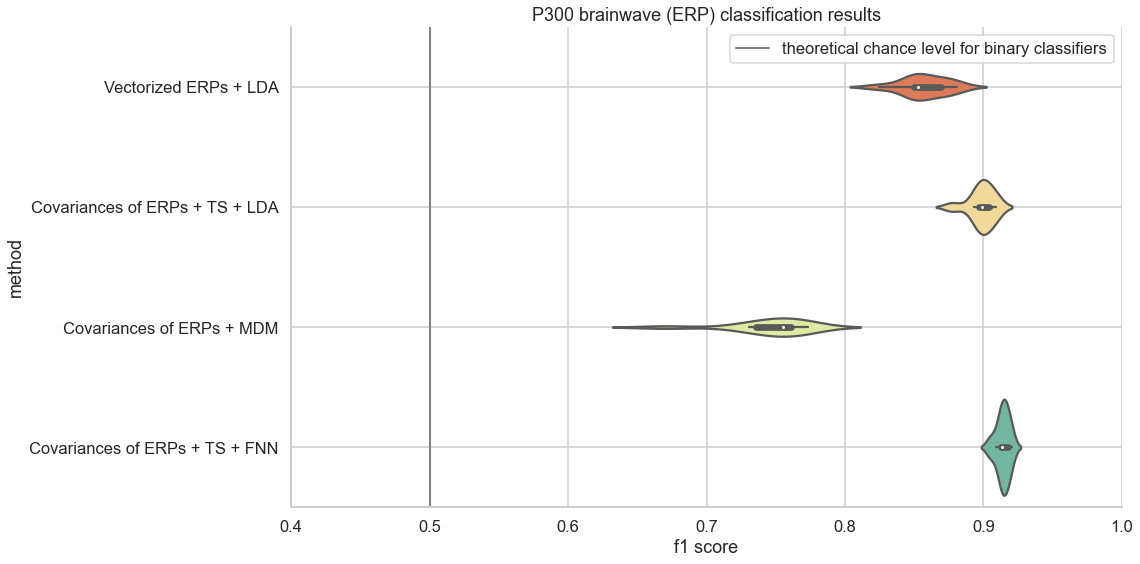

In [15]:
sns.set_context('talk')
sns.set_style('whitegrid')

results = pd.DataFrame(data=auc, columns=['f1 score'])
results['method'] = methods

fig_viol = plt.figure(figsize=[16,8])
plt.rcParams.update({'font.size': 12})
sns.violinplot(data=results, x='f1 score', y='method', palette=sns.color_palette("Spectral", len(clfs)))

plt.axvline(x=0.5, color='gray',lw=2, label='theoretical chance level for binary classifiers')
plt.xlim(0.40, 1.0)
sns.despine()
plt.legend()
plt.grid(True)
plt.title('P300 brainwave (ERP) classification results')
fig_viol.tight_layout()